In [50]:
%pip install tensorflow keras pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [53]:
# Đọc dữ liệu MovieLens 1M
file_path = r"C:\Thesis\Sample Project\Data\Dataset\ratings.dat"
column_names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_csv(file_path, sep='::', names=column_names, engine='python')

data = data.drop(columns=["timestamp"])  # Bỏ cột timestamp

In [54]:

# Load thêm dữ liệu người dùng và phim
users = pd.read_csv(r"C:\Thesis\Sample Project\Data\Dataset\users.dat", sep='::', engine='python',
                    names=["user_id", "gender", "age", "occupation", "zip"], encoding='latin-1')
movies = pd.read_csv(r"C:\Thesis\Sample Project\Data\Dataset\movies.dat", sep='::', engine='python',
                     names=["item_id", "title", "genres"], encoding='latin-1') 

# Encode các cột phân loại
from sklearn.preprocessing import LabelEncoder
gender_enc = LabelEncoder()
occupation_enc = LabelEncoder()
age_enc = LabelEncoder()
genre_enc = LabelEncoder()

users["gender"] = gender_enc.fit_transform(users["gender"])
users["occupation"] = occupation_enc.fit_transform(users["occupation"])
users["age"] = age_enc.fit_transform(users["age"])

# Với genres có nhiều thể loại, tạm thời chỉ lấy thể loại đầu tiên
movies["genres"] = movies["genres"].apply(lambda x: x.split('|')[0])
movies["genres"] = genre_enc.fit_transform(movies["genres"])

# In dữ liệu để kiểm tra
print("Gender Mapping:", dict(zip(gender_enc.classes_, gender_enc.transform(gender_enc.classes_))))
print("Age Mapping:", dict(zip(age_enc.classes_, age_enc.transform(age_enc.classes_))))
print("Occupation Mapping:", dict(zip(occupation_enc.classes_, occupation_enc.transform(occupation_enc.classes_))))
print("Genre Mapping:", dict(zip(genre_enc.classes_, genre_enc.transform(genre_enc.classes_))))

# Gộp dữ liệu lại
data = data.merge(users, on="user_id")
data = data.merge(movies, on="item_id")


Gender Mapping: {'F': 0, 'M': 1}
Age Mapping: {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}
Occupation Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20}
Genre Mapping: {'Action': 0, 'Adventure': 1, 'Animation': 2, "Children's": 3, 'Comedy': 4, 'Crime': 5, 'Documentary': 6, 'Drama': 7, 'Fantasy': 8, 'Film-Noir': 9, 'Horror': 10, 'Musical': 11, 'Mystery': 12, 'Romance': 13, 'Sci-Fi': 14, 'Thriller': 15, 'War': 16, 'Western': 17}


In [55]:
# Drop user_id (vì không dùng)
data = data.drop(columns=["user_id"])

item_encoder = LabelEncoder()
data["item_id"] = item_encoder.fit_transform(data["item_id"])

# Cập nhật số lượng item để dùng cho model
num_items = data["item_id"].nunique()

# Chia tập huấn luyện và kiểm tra
train, test = train_test_split(data, test_size=0.2, random_state=42)


In [56]:
def build_deepfm(num_items, num_genres, num_genders, num_ages, num_occupations,
                embedding_dim=8, hidden_dims=[64, 32], dropout=0.5):

    # Inputs
    gender_input = layers.Input(shape=(1,), name='gender')
    age_input = layers.Input(shape=(1,), name='age')
    occupation_input = layers.Input(shape=(1,), name='occupation')
    item_input = layers.Input(shape=(1,), name='item_id')
    genre_input = layers.Input(shape=(1,), name='genre')

    # Embeddings
    gender_emb = layers.Embedding(num_genders, embedding_dim)(gender_input)
    age_emb = layers.Embedding(num_ages, embedding_dim)(age_input)
    occupation_emb = layers.Embedding(num_occupations, embedding_dim)(occupation_input)
    item_emb = layers.Embedding(num_items, embedding_dim)(item_input)
    genre_emb = layers.Embedding(num_genres, embedding_dim)(genre_input)

    # Flatten
    gender_flat = layers.Flatten()(gender_emb)
    age_flat = layers.Flatten()(age_emb)
    occupation_flat = layers.Flatten()(occupation_emb)
    item_flat = layers.Flatten()(item_emb)
    genre_flat = layers.Flatten()(genre_emb)

    # User profile vector (kết hợp thông tin người dùng)
    user_profile = layers.Concatenate()([gender_flat, age_flat, occupation_flat])
    user_vector = layers.Dense(embedding_dim)(user_profile)

    # 📌 FM tương tác giữa user và item
    fm_user_item = layers.Dot(axes=1)([user_vector, item_flat])
    fm_genre_user = layers.Dot(axes=1)([genre_flat, user_vector])

    # 🧠 DNN
    concat = layers.Concatenate()([user_profile, item_flat, genre_flat])
    dnn = concat
    for dim in hidden_dims:
        dnn = layers.Dense(dim, activation='relu')(dnn)
        dnn = layers.Dropout(dropout)(dnn)
    dnn_out = layers.Dense(1)(dnn)

    # 🎯 Output
    output = layers.Add()([fm_user_item, fm_genre_user, dnn_out])
    output = layers.Activation('sigmoid')(output)

    model = keras.Model(
        inputs=[gender_input, age_input, occupation_input, item_input, genre_input],
        outputs=output
    )
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


In [57]:
# Chuẩn bị số lượng danh mục (category) cho embedding
num_genders = data["gender"].nunique()
num_ages = data["age"].nunique()
num_occupations = data["occupation"].nunique()
num_genres = data["genres"].nunique()

# Khởi tạo mô hình
embedding_dim = 8
hidden_dims = [64, 32]
dropout = 0.5

model = build_deepfm(
    num_items, num_genres, num_genders, num_ages, num_occupations,
    embedding_dim=8, hidden_dims=[64, 32], dropout=0.5
)

model.summary()
# Kiểm tra mô hình

# Chuyển đổi dữ liệu đầu vào
X_train = [
    train["gender"].values,
    train["age"].values,
    train["occupation"].values,
    train["item_id"].values,
    train["genres"].values
]
y_train = (train["rating"].values >= 4).astype(int)

X_test = [
    test["gender"].values,
    test["age"].values,
    test["occupation"].values,
    test["item_id"].values,
    test["genres"].values
]
y_test = (test["rating"].values >= 4).astype(int)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 occupation (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 1, 8)                 16        ['gender[0][0]']              
                                                                                            

In [65]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, batch_size=256, epochs=10,
                    validation_data=(X_test, y_test), verbose=1)

# Đánh giá
loss, acc, auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")

Epoch 1/10
3126/3126 [==============================] - 9s 3ms/step - loss: 0.5671 - accuracy: 0.7040 - auc: 0.7620 - val_loss: 0.5995 - val_accuracy: 0.6842 - val_auc: 0.7327
Epoch 2/10
3126/3126 [==============================] - 8s 3ms/step - loss: 0.5670 - accuracy: 0.7040 - auc: 0.7621 - val_loss: 0.5998 - val_accuracy: 0.6843 - val_auc: 0.7326
Epoch 3/10
3126/3126 [==============================] - 8s 3ms/step - loss: 0.5669 - accuracy: 0.7041 - auc: 0.7623 - val_loss: 0.6000 - val_accuracy: 0.6836 - val_auc: 0.7321
Epoch 4/10
3126/3126 [==============================] - 8s 3ms/step - loss: 0.5669 - accuracy: 0.7039 - auc: 0.7622 - val_loss: 0.6003 - val_accuracy: 0.6841 - val_auc: 0.7323
Epoch 5/10
3126/3126 [==============================] - 8s 3ms/step - loss: 0.5668 - accuracy: 0.7042 - auc: 0.7624 - val_loss: 0.6000 - val_accuracy: 0.6836 - val_auc: 0.7319
Epoch 6/10
3126/3126 [==============================] - 8s 3ms/step - loss: 0.5667 - accuracy: 0.7045 - auc: 0.7624 - va

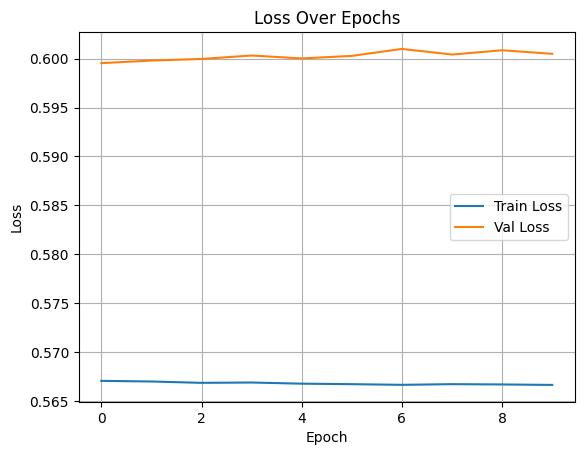

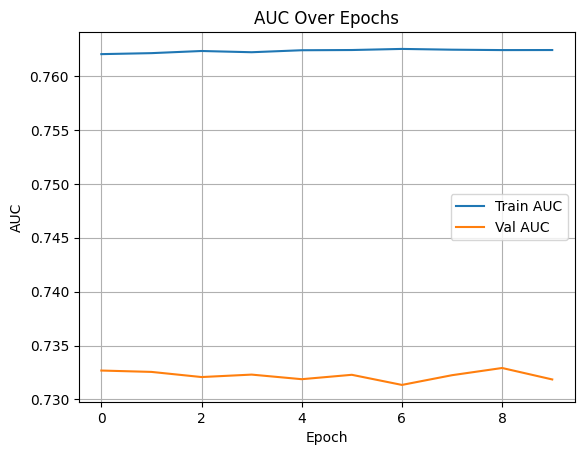

In [66]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# AUC
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


In [67]:
# Lưu mô hình
model.save("deepfm_model.keras")